# Mini Spark Broker: Early classification and external database

author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-02-06


The purpose of this notebook is to test Spark capability to connect to external database such as the CDS Strasbourg, and perform real-time classification for known objects. We use the CDS X-Match service (http://cdsxmatch.u-strasbg.fr/), and the SIMBAD bibliographical database (updated each day). 

**Useful Links:**

* https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
* http://cdsxmatch.u-strasbg.fr/xmatch/doc/index.html

In [1]:
from pyspark.sql import SparkSession

import io
import time
import requests
from typing import Iterator, Generator

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from desc.msb import avroUtils
from desc.msb.filtering import make_dataframe_from_alerts
from desc.msb.filtering import extract_history_ztf

## Step 0: Running the LSST alert system

In order to play with this notebook, you need to create the stream of alerts. see the README file of the bootcamp to set up your environment and launch the stream.

## Step 1: Connecting to the stream with Apache Spark

Once the stream is produced, let's initialise the Spark context:

In [2]:
# Grab the running Spark Session, 
# otherwise create it.
spark = SparkSession \
    .builder \
    .appName("filtering") \
    .getOrCreate()

Let's initialise a DataFrame that will read the stream from Kafka. Note that `kafka.bootstrap.servers` and `subscribe` must correspond to the arguments used for the LSST alert system (see above). At this point, we just create a Kafka Source for Streaming Queries - nothing really happens:

In [3]:
# Create a DF from the incoming stream from Kafka
# Note that <kafka.bootstrap.servers> and <subscribe>
# must correspond to arguments of the LSST alert system.
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "ztf-stream") \
  .option("startingOffsets", "earliest") \
  .load()

df.isStreaming

True

As you can see, `df` is a streaming Dataframe. You can start streaming computation, by defining the sink and starting it. 
<!-- In our case, we want to interactively query the counts (same queries as above), so we will set the complete set of 1 hour counts to be in a in-memory table (note that this for testing purpose only in Spark 2.0). -->

## Step 2: Filtering the stream

In this section, we will design simple fiters to interact with the stream and extract only relevant information for us. Let's first create a sink and grab all the alerts:

In [4]:
rawQuery = df\
    .writeStream \
    .queryName("qraw")\
    .format("memory")\
    .start()

In [5]:
# Give a bit of time for synchronisation
time.sleep(10)

In [11]:
!ps -ef | grep spark-shell

jovyan      48    30  2 21:35 ?        00:00:26 /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java -cp /usr/local/spark/conf/:/usr/local/spark/jars/* -Xmx1g org.apache.spark.deploy.SparkSubmit --name PySparkShell --packages org.apache.spark:spark-streaming-kafka-0-10-assembly_2.10:2.2.0,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.0 pyspark-shell
jovyan     138   116 15 21:36 ?        00:02:53 /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java -cp /usr/local/spark/conf/:/usr/local/spark/jars/* -Xmx1g org.apache.spark.deploy.SparkSubmit --name PySparkShell --packages org.apache.spark:spark-streaming-kafka-0-10-assembly_2.10:2.2.0,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.0 pyspark-shell
jovyan     480   464  2 21:42 ?        00:00:18 /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java -cp /usr/local/spark/conf/:/usr/local/spark/jars/* -Xmx1g org.apache.spark.deploy.SparkSubmit --name PySparkShell --packages org.apache.spark:spark-streaming-kafka-0-10-assembly_2.10:2.2.0,org.apache.spark:spark

In [15]:
!kill -9 116

In [16]:
# Construct your DataFrame with data from Kafka
df_raw = spark.sql("select * from qraw")
df_raw.show(10)

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|null|[06 33 2E 32 32 5...|ztf-stream|        0|   998|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|   999|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|  1000|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|  1001|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|  1002|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|  1003|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|  1004|2019-04-01 21:08:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|  1005|2019-04-01 21:08:...|            0|

We can look closely at the columns of this Dataframe:

In [17]:
df_raw.printSchema()
df_raw.describe().show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------+----------+---------+------------------+-------------+
|summary|     topic|partition|            offset|timestampType|
+-------+----------+---------+------------------+-------------+
|  count|       499|      499|               499|          499|
|   mean|      null|      0.0|            1247.0|          0.0|
| stddev|      null|      0.0|144.19315748906627|          0.0|
|    min|ztf-stream|        0|               998|            0|
|    max|ztf-stream|        0|              1496|            0|
+-------+----------+---------+------------------+-------------+



The column of interest for us is `value` which contains the alert data. For the moment, the data is `binary`, so let's decode it. First read the corresponding schema (ZTF in this example):

In [18]:
# Read the schema
alert_schema = avroUtils.readSchemaFromAvroFile("../schemas/template_schema_ZTF.avro")

# Broadcast the schema to all Spark executors
# (Keep in mind we work in a distributed environment!)
sc.broadcast(alert_schema)

# Look at the available keys
print(alert_schema.keys())

dict_keys(['type', 'version', 'name', 'namespace', 'fields', 'doc'])


Now we have the schema, we can decode the alerts. For technical reason, you need to go to RDD world to use in a meaningful way the decoder:

In [19]:
# RDD: Resilient Distributed Dataset.
# Both Spark DataFrames and RDDs are distributed memory abstractions, fault-tolerant and immutable.
# The main difference is that Dataframes are organized into named columns with defined 
# data types and including the benefits of Spark SQL's execution engine.
# Historically, there were only RDDs. DataFrame came later in Spark.
rdd_alerts = df_raw.select("value").rdd.map(lambda x: avroUtils.decoder(x.value, alert_schema))

And here is one full alert:

In [20]:
rdd_alerts.take(1)[0].keys()

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])

### Classifying alerts

In this section, we want to classify the alerts into 2 big classes: known objects vs unknown objects. And for known objects, we want to retrieve known information such as the name and type of each object. It is a standard problem of cross-match, but in real-time! In order to not rely on hard-coded catalogs, we will connect to remote databases, and query them with the data in our alerts (ra/dec-based).

We want to connect to the CDS Strasbourg, and perform real-time classification for known objects. We use the CDS X-Match service (http://cdsxmatch.u-strasbg.fr/), and the SIMBAD bibliographical database (updated each day). 

Let's first inspect output from the CDS X-Match service:

In [21]:
# Build fake table of RA,DEC,objectID
table = """ra_in,dec_in,objectId
7.465000,38.324167,toto
9.805417,3.134167,titi
10.665417,71.366944,tata
233.190417,68.866667,tutu
"""

r = requests.post(
         'http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync',
         data={'request': 'xmatch', 'distMaxArcsec': 5, 'RESPONSEFORMAT': 'csv',
         'cat2': 'simbad', 'colRA1': 'ra_in', 'colDec1': 'dec_in'},
         files={'cat1': table})

print(r.text.replace("\n", "\n\n"))

angDist,ra_in,dec_in,objectId,main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,nbref,ra_sexa,dec_sexa,main_type,other_types,radvel,redshift,sp_type,morph_type,plx,pmra,pmdec,size_maj,size_min,size_angle,B,V,R,J,H,K,u,g,r,i,z

0.745488,7.465,38.324167,toto,HD   2611,7.4652624005,+38.3241445286,0.000,0.000,90,13,00 29 51.66298,+38 19 26.9203,PM*,*  |IR |UV |PM*,-32.4400,,F8,,12.8013,-49.47,-84.98,,,,7.970,7.450,,6.466,6.272,6.212,,,,,

1.010772,9.805417,3.134167,titi,HD   3628,9.8052720833,+3.1339263889,0.000,0.000,90,108,00 39 13.2653 ,+03 08 02.135 ,PM*,V* |IR |*  |PM*|PM*|PM*,-27.2100,,G3V,,23.0200,783.71,297.93,,,,7.980,7.300,6.900,6.192,5.896,5.806,,,,,

1.357510,10.665417,71.366944,tata,BD+70    39B,10.6647407637,+71.3672530503,0.000,0.000,90,8,00 42 39.53778,+71 22 02.1110,Star,** |*  |IR,-11.0000,,A1,,3.4957,19.97,-7.84,,,,8.070,8.050,,7.847,7.859,7.902,,,,,

4.120559,10.665417,71.366944,tata,HD   3891,10.6668410096,+71.3658937187,0.007,0.007,90,16,00 42 40.04184,+71 21 57.21

OK it returns many things, and among those we are mainly interested in `ra_in,dec_in,objectId,main_id,main_type` to see if the alert corresponds to something known.

Let's do via Spark. It requires a bit of tweaking so avoid overcrowding the CDS servers with too many requests. The idea is to send a list of alerts at once. The list will be generating inside each Spark partition (only one partition in this local example), and then we build a Dataframe with outputs:

In [22]:
def cross_match_alerts(partition: Iterator) -> Generator:
    """ Query the CDSXmatch service to find identified objects
    in alerts. The catalog queried is the SIMBAD bibliographical database.
    We can also use the 10,000+ VizieR tables if needed :-)
    
    Parameters
    ----------
    part: Iterator
        Spark partition containing alert ID, ra, dec.
    
    Returns
    ----------
    out: Generator of tuples 
        Tuple with (objectId, ra, dec, name, type).
        If the object is not found in Simbad, name & type
        are marked as Unknown. In the case several objects match
        the centroid of the alert, only the closest is returned.
    """
    # Unwrap partition data
    data = [*partition]
    oid, ra, dec = np.transpose(data)
    
    def generate_csv(s: str, lra: list, ldec: list, loid: list):
        """ Insert (lra[i],ldec[i],loid[i]) rows recursively in s.
        
        Parameters
        ----------
        s: str
            String which will contain the data.
            Should initially contain the CSV header.
        lra: list of float
            List of RA
        ldec: list of float
            List of Dec of the same size as lra.
        loid: list of str
            List of object ID used to match input with output
            
        Returns
        ----------
        s: str
            Updated string with one row per line.
        """
        if len(lra) > 0:
            s = s + "{},{},{}\n ".format(lra[0], ldec[0], loid[0])
            return generate_csv(s, lra[1:], ldec[1:], loid[1:])
        else:
            return s
    
    # Build a catalog of alert in a CSV-like string
    table_header = """ra_in,dec_in,objectId\n"""
    table = generate_csv(table_header, ra, dec, oid)
    
    # Send the request!
    r = requests.post(
         'http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync',
         data={
             'request': 'xmatch', 
             'distMaxArcsec': 1, 
             'selection': 'all',
             'RESPONSEFORMAT': 'csv',
             'cat2': 'simbad', 
             'colRA1': 'ra_in', 
             'colDec1': 'dec_in'},
         files={'cat1': table})
    
    # Decode the message, and split line by line
    # First line is header - last is empty
    data = r.content.decode().split("\n")[1:-1]
    header = r.content.decode().split("\n")[0].split(",")
    
    # Fields of interest (their indices in the output)
    main_id = header.index("main_id")
    main_type = header.index("main_type")
    ra_ind = header.index("ra_in")
    dec_ind = header.index("dec_in")
    oid_ind = header.index("objectId")
    
    # Get the (ra, dec) of matches
    radec_out = [
        (float(np.array(i.split(","))[ra_ind]), 
         float(np.array(i.split(","))[dec_ind])) for i in data]
    
    # Get the objectId of matches
    id_out = [np.array(i.split(","))[oid_ind] for i in data]
    
    # Get the names of matches
    names = [np.array(i.split(","))[main_id] for i in data]
    
    # Get the types of matches
    types = [np.array(i.split(","))[main_type] for i in data]
    
    # Assign names and types to inputs
    out = []
    for ra_in, dec_in, id_in in zip(ra, dec, oid):
        # cast for picky Spark
        ra_in, dec_in = float(ra_in), float(dec_in)
        id_in = str(id_in)
        
        # Discriminate with the objectID
        if id_in in id_out:
            # Return the closest object in case of many (smallest angular distance)
            index = id_out.index(id_in)
            out.append((id_in, ra_in, dec_in, str(names[index]), str(types[index])))
        else:
            # Mark as unknown if no match
            out.append((id_in, ra_in, dec_in, "Unknown", "Unknown"))
    
    yield out

In [23]:
# Pipeline for real-time classification
colnames_input = [
    "objectId",
    "candidate:ra", "candidate:dec"
]

df_simple = make_dataframe_from_alerts(rdd_alerts, colnames_input)

colnames_output = [
    "objectId", 
    "candidate:ra", "candidate:dec", 
    "Closest Simbad object", "type"
]

df_type = (df_simple.rdd
    # Send request to CDS and return matches
    .mapPartitions(lambda x: cross_match_alerts(x))
    # Flatten the output
    .flatMap(lambda x: x)
    # Make a Dataframe
    .toDF(colnames_output))

df_type.show(10)

+------------+------------+-------------+---------------------+-------+
|    objectId|candidate:ra|candidate:dec|Closest Simbad object|   type|
+------------+------------+-------------+---------------------+-------+
|ZTF18abyouwp|  26.8566983|  -26.9677112|       TYC 6431-115-1|   Star|
|ZTF18acsbjqe|    26.24497|  -26.7569436|              Unknown|Unknown|
|ZTF18acaixum|  26.1126147|  -26.8053928|              Unknown|Unknown|
|ZTF18acsbjqg|  25.5844032|  -27.9239037|              Unknown|Unknown|
|ZTF18acsbjqi|  25.5902591|  -27.9131274|              Unknown|Unknown|
|ZTF18acsbjqf|  26.0145383|  -27.9003972|              Unknown|Unknown|
|ZTF18acsbjqh|  25.6648433|  -27.8417869|              Unknown|Unknown|
|ZTF18acsbjou|  24.4538066|  -27.0766656|              Unknown|Unknown|
|ZTF18abvdmcb|  24.9350326|  -26.5438418| CRTS J013944.5-26...|  RRLyr|
|ZTF18acsbjpf|   23.517342|  -27.0446981|              Unknown|Unknown|
+------------+------------+-------------+---------------------+-

Neat! And fast! Let's group alerts by object types:

In [24]:
df_group = df_type.groupBy("type").count()
df_group.show()

# Check we did not miss alerts
assert(df_simple.count() == np.sum(df_group.select("count").rdd.collect()))

+-------------+-----+
|         type|count|
+-------------+-----+
|        GinCl|    1|
|          AGN|    1|
|   PulsV*WVir|    1|
|Candidate_EB*|    1|
|      EB*WUMa|   16|
|        AMHer|    1|
|      Unknown|  375|
|          HB*|    4|
|AGN_Candidate|    1|
|         Blue|    1|
|    Seyfert_1|    3|
|    EB*betLyr|    1|
|         LPV*|    1|
|        BLLac|    2|
|          QSO|    2|
|         Star|   25|
|        RRLyr|   63|
+-------------+-----+



And plot it:

In [25]:
pandas_df = df_group.toPandas()

Text(0.5,0,'Alert entry')

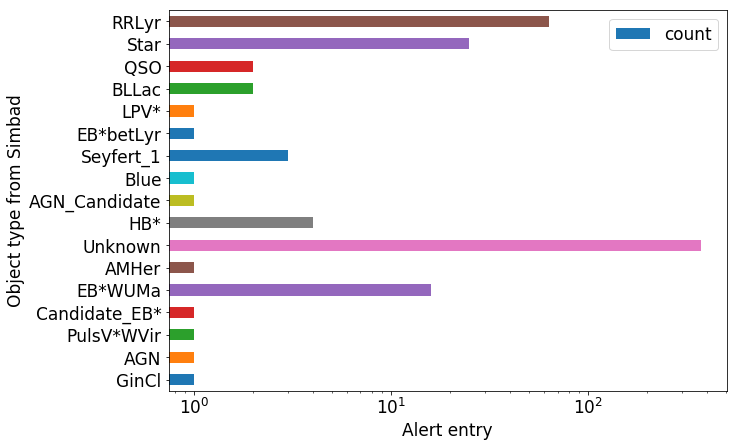

In [26]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
pandas_df.plot("type", "count", kind="barh", ax=ax)
ax.set_xscale("log")
ax.set_ylabel("Object type from Simbad")
ax.set_xlabel("Alert entry")

For description of types, see: http://cds.u-strasbg.fr/cgi-bin/Otype?X

Et voilà!